In [ ]:
!pip install adlfs
!pip install keras-tuner --quiet


#### IMPORTS

In [ ]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
import sys

from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

from typing import Tuple, List, Optional
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split



# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import class_weight

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras_tuner import RandomSearch


#### FUNCTIONS

In [ ]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)


    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df

In [ ]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float, np.ndarray, float, float]:
    """
    Evaluates the classification model and plots metrics.

    Args:
        y_test (pd.Series): True target values.
        y_pred (pd.Series): Predicted class values.
        y_prob (pd.Series): Predicted probabilities for class 1.

    Returns:
        Tuple containing Accuracy, F1 Score, ROC AUC, Confusion Matrix, Precision, Recall.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc, cm, precision, recall


In [ ]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans a DataFrame by dropping unnecessary columns and handling missing values.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Columns to drop (consistent with SVM and Naive Bayes pipelines)
    columns_to_drop = [
    'capital_gains', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y',"price_lead_3m", "price_lead_6m", "price_lead_1y"]

    print(f"Shape before: {df.shape}")
    df = df.drop(columns=columns_to_drop, errors='ignore').copy()

    numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
    imputer = SimpleImputer(strategy="mean")
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    print(f"Shape after: {df.shape}")
    return df


In [ ]:
def prepare_data_with_symbol_date(df: pd.DataFrame, targets: list):
    """
    Prepares a DataFrame for LSTM modeling: encodes 'symbol', extracts 'date' features,
    imputes missing values, and applies MinMax scaling.

    Args:
        df (pd.DataFrame): Input data with features + target + symbol + date.
        targets (list): List of target column names.

    Returns:
        pd.DataFrame: Scaled dataframe with 'symbol' and 'date' incorporated as features.
        MinMaxScaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Convert date and extract features
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
    df_clean["year"] = df_clean["date"].dt.year
    df_clean["month"] = df_clean["date"].dt.month
    df_clean["dayofweek"] = df_clean["date"].dt.dayofweek

    date_col = df_clean["date"]  # store datetime (not string)

    # Encode symbol (remains numeric)
    df_clean["symbol"] = LabelEncoder().fit_transform(df_clean["symbol"].astype(str))

    # Drop original date before scaling
    df_clean = df_clean.drop(columns=["date"], errors="ignore")

    for col in df_clean.select_dtypes(include=["object", "category"]).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)

    # Reattach encoded symbol and original date
    df_scaled["symbol"] = df_clean["symbol"].values
    df_scaled["date"] = date_col.values

    print(f"columnas scaler: {X.columns}")
    return df_scaled, scaler


In [ ]:
def prepare_data_with_symbol_date_k_features(
    df: pd.DataFrame,
    target: str,
    k_best: int = 30
):
    """
    Prepares a DataFrame for LSTM modeling: encodes 'symbol', extracts 'date' features,
    imputes missing values, selects top-k features, applies MinMax scaling.

    Args:
        df (pd.DataFrame): Input data with features + target + symbol + date.
        target (str): Target column name.
        k_best (int): Number of top features to select.

    Returns:
        pd.DataFrame: Scaled dataframe with selected features plus 'symbol', 'date', and target.
        MinMaxScaler: The fitted scaler object.
        List[str]: List of selected feature names.
    """
    df_clean = df.copy()

    # Convert date and extract features
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
    df_clean["year"] = df_clean["date"].dt.year
    df_clean["month"] = df_clean["date"].dt.month
    df_clean["dayofweek"] = df_clean["date"].dt.dayofweek

    date_col = df_clean["date"]

    # Encode symbol
    df_clean["symbol"] = LabelEncoder().fit_transform(df_clean["symbol"].astype(str))

    # Drop original date before scaling
    df_clean = df_clean.drop(columns=["date"], errors="ignore")

    for col in df_clean.select_dtypes(include=["object", "category"]).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    feature_cols = [col for col in df_clean.columns if col != target]
    X = df_clean[feature_cols]
    y = df_clean[target]

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # Select top-k features
    selector = SelectKBest(score_func=f_classif, k=k_best)
    X_selected = selector.fit_transform(X_imputed, y)
    selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_selected)

    df_scaled = pd.DataFrame(X_scaled, columns=selected_features, index=df_clean.index)

    # Reattach symbol, date, and target
    df_scaled["symbol"] = df_clean["symbol"].values
    df_scaled["date"] = date_col.values
    df_scaled[target] = y.values

    print(f"Scaled columns used: {selected_features}")

    return df_scaled, scaler, selected_features


In [ ]:
def build_and_split_sequences_by_symbol(
    df: pd.DataFrame,
    target_column: str,
    sequence_length: int = 60,
    test_size: float = 0.2
):
    """
    Builds sequential data for each symbol independently and performs temporal train-test split.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features, target, 'symbol' and 'date'.
        target_column (str): Column name for binary target.
        sequence_length (int): Time window for each sequence.
        test_size (float): Proportion of test samples (applied per symbol).

    Returns:
        Tuple of numpy arrays: X_train, X_test, y_train, y_test
    """
    X_train, y_train, X_test, y_test = [], [], [], []

    symbols = df["symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")

        if len(df_symbol) <= sequence_length:
            continue  # Skip if not enough data

        df_symbol[target_column] = df_symbol[target_column].astype(int)
        features = df_symbol.drop(
            columns=["date", "target_3m", "target_6m", "target_1y"],
            errors="ignore"
        )

        #print(f" las features son : {features.columns}")
        target = df_symbol[target_column].values

        split_idx = int(len(features) * (1 - test_size))
        for i in range(len(features) - sequence_length):
            if i + sequence_length >= len(features):
                continue

            X_seq = features.iloc[i:i + sequence_length].values.astype(np.float32)
            y_val = target[i + sequence_length]

            if i + sequence_length < split_idx:
                X_train.append(X_seq)
                y_train.append(y_val)
            else:
                X_test.append(X_seq)
                y_test.append(y_val)

    return (
        np.array(X_train),
        np.array(X_test),
        np.array(y_train),
        np.array(y_test)
    )

In [ ]:
def train_base_lstm_classifier(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=60,
    epochs=30,
    batch_size=32,
    patience=4,
    class_weight=None
):
    """
    Trains a simple LSTM classifier with basic architecture and early stopping.

    Args:
        X_train (np.ndarray): Training sequences.
        X_test (np.ndarray): Test sequences.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Test labels.
        sequence_length (int): Length of each input sequence.
        epochs (int): Maximum number of epochs.
        batch_size (int): Batch size.
        patience (int): Early stopping patience.
        class_weight (dict, optional): Class weights to handle imbalance.

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test labels.
        y_prob (np.ndarray): Predicted probabilities.
        y_pred (np.ndarray): Predicted binary classes.
        history: Keras training history object.
    """
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred, history


In [ ]:

def train_improved_lstm_classifier(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=120,
    epochs=30,
    batch_size=32,
    patience=3,
    learning_rate=1e-4,
    threshold=0.5,
    class_weight=None
):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > threshold).astype(int)

    return model, X_test, y_test, y_prob, y_pred, history

# **MAIN**

In [ ]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']

# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)
df_full = df_full.dropna(subset=['ret_next_3m', 'ret_next_6m', 'ret_next_1y'])



folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

In [ ]:
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.1).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.1).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.1).astype(int)

In [ ]:
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_20_symbols = df_full[df_full["symbol"].isin(top_symbols)].copy()

top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_100_symbols = df_full[df_full["symbol"].isin(top_symbols)].copy()

top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_500_symbols = df_full[df_full["symbol"].isin(top_symbols)].copy()

**# 20 symbols**

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'price_range', 'log_return', 'is_dividend_day', 'sma_5', 'sma_20', 'bollinger_upper', 'bollinger_lower', 'rel_volume', 'ema_12', 'ema_26', 'macd_histogram', 'tr_1', 'tr_3', 'lower_wick', 'var_95', 'target_6m', 'target_1y', 'year', 'month']
types: symbol                          int64
open_v                        float64
high                          float64
low                           float64
close_v                       float64
volume                        float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
price_range                   float64
log_return                    float64
is_dividend_day               float64
sm

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5496 - auc: 0.5566 - loss: 0.6869 - val_accuracy: 0.5096 - val_auc: 0.5302 - val_loss: 0.7049
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.5643 - auc: 0.6193 - loss: 0.6719 - val_accuracy: 0.6141 - val_auc: 0.5246 - val_loss: 0.6940
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.5836 - auc: 0.6495 - loss: 0.6552 - val_accuracy: 0.6360 - val_auc: 0.5677 - val_loss: 0.6975
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.6010 - auc: 0.6569 - loss: 0.6528 - val_accuracy: 0.6515 - val_auc: 0.5886 - val_loss: 0.6628
Epoch 5/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5854 - auc: 0.6456 - loss: 0.6591 - val_accuracy: 0.5965 - val_auc: 0.5559 - val_loss: 0.6874
Epoch 6/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5946 - auc: 0.6660 - loss: 0.6459 - val_accuracy: 0.5965 - val_auc: 0.5654 - val_loss: 0.7052
Epoch 7/30
3012/

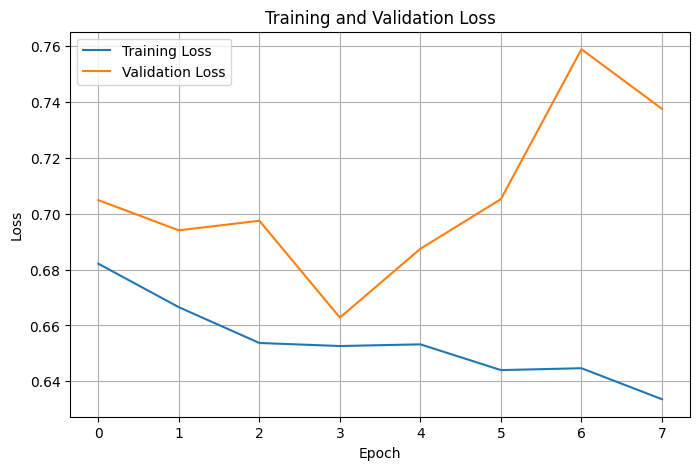

Accuracy: 0.6515
F1 Score: 0.3486
ROC AUC: 0.5886
Confusion Matrix:
[[14012  2906]
 [ 5841  2341]]
Precision: 0.4462
Recall: 0.2861


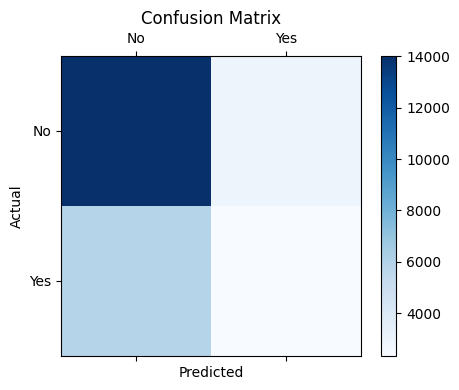

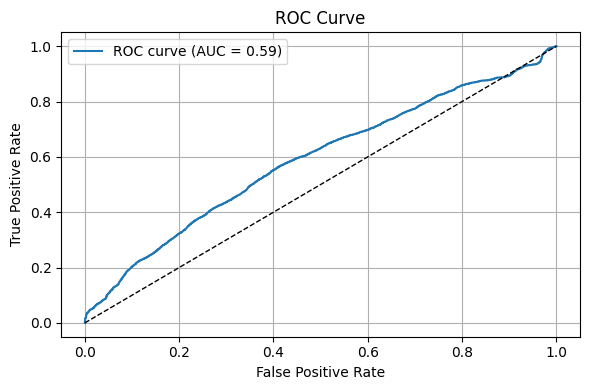

(0.6515139442231076,
 0.3486484473899769,
 np.float64(0.5886030556061331),
 array([[14012,  2906],
        [ 5841,  2341]]),
 0.4461597103106537,
 0.2861158640919091)

In [ ]:
# train_base_lstm_classifier LSTM, 20 symbols, target_3m
target_column = 'target_3m'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'price_range', 'log_return', 'is_dividend_day', 'sma_5', 'sma_20', 'bollinger_upper', 'bollinger_lower', 'rel_volume', 'ema_12', 'ema_26', 'macd_histogram', 'tr_1', 'tr_3', 'lower_wick', 'var_95', 'target_6m', 'target_1y', 'year', 'month']
types: symbol                          int64
open_v                        float64
high                          float64
low                           float64
close_v                       float64
volume                        float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
price_range                   float64
log_return                    float64
is_dividend_day               float64
sm

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 125s 40ms/step - accuracy: 0.4974 - auc: 0.5131 - loss: 0.8218 - precision: 0.2958 - recall: 0.5352 - val_accuracy: 0.5669 - val_auc: 0.5539 - val_loss: 0.7022 - val_precision: 0.3538 - val_recall: 0.3978
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.5401 - auc: 0.5592 - loss: 0.7109 - precision: 0.3221 - recall: 0.5420 - val_accuracy: 0.6021 - val_auc: 0.5462 - val_loss: 0.6852 - val_precision: 0.3711 - val_recall: 0.3179
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 121s 40ms/step - accuracy: 0.5652 - auc: 0.5998 - loss: 0.6838 - precision: 0.3501 - recall: 0.5818 - val_accuracy: 0.6137 - val_auc: 0.5387 - val_loss: 0.6909 - val_precision: 0.3824 - val_recall: 0.3010
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.5729 - auc: 0.6208 - loss: 0.6702 - precision: 0.3596 - recall: 0.6132 - val_accuracy: 0.5819 - val_auc: 0.5428 - val_loss: 0.7009 - val_precision: 0.3641 - val_recall: 0.3784
785/785 ━━━━

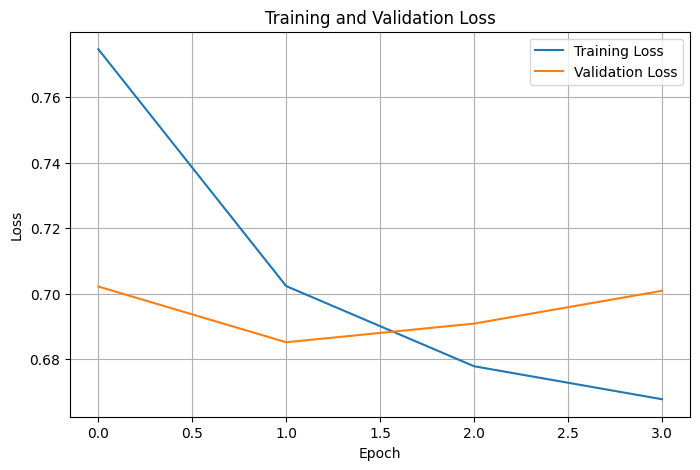

Accuracy: 0.5669
F1 Score: 0.3745
ROC AUC: 0.5539
Confusion Matrix:
[[10973  5945]
 [ 4927  3255]]
Precision: 0.3538
Recall: 0.3978


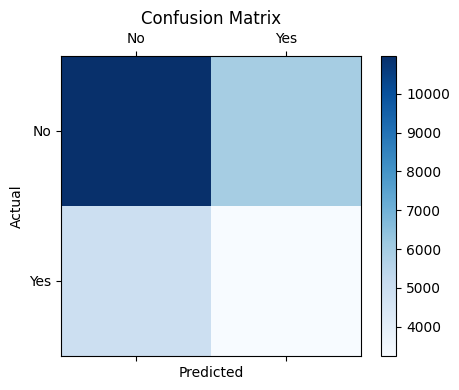

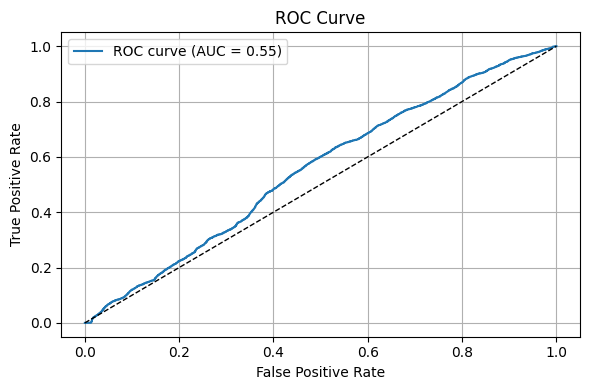

(0.5668525896414343,
 0.37452537107352435,
 np.float64(0.5539293101679087),
 array([[10973,  5945],
        [ 4927,  3255]]),
 0.35380434782608694,
 0.39782449278904913)

In [ ]:
# train_improved_lstm_classifier LSTM, 20 symbols, target_3m
target_column = 'target_3m'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'intraday_volatility', 'price_range', 'sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'roc_10', 'var_95', 'target_3m', 'target_1y', 'year', 'month']
types: symbol                          int64
open_v                        float64
high                          float64
low                           float64
close_v                       float64
prev_close                    float64
intraday_volatility           float64
price_range                   float64
sma_5                         float64
sma_20                        float64
rsi_14                        float64
bollinger_upper               float64
bollinger_lower               float64
ema_12                        float64
ema_26                        flo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.5379 - auc: 0.5566 - loss: 0.6888 - val_accuracy: 0.5417 - val_auc: 0.5191 - val_loss: 0.7384
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.5735 - auc: 0.6074 - loss: 0.6726 - val_accuracy: 0.5406 - val_auc: 0.5299 - val_loss: 0.6966
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.5915 - auc: 0.6369 - loss: 0.6615 - val_accuracy: 0.5390 - val_auc: 0.5169 - val_loss: 0.7619
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.6223 - auc: 0.6733 - loss: 0.6417 - val_accuracy: 0.5260 - val_auc: 0.5427 - val_loss: 0.8152
Epoch 5/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.6334 - auc: 0.6837 - loss: 0.6389 - val_accuracy: 0.5566 - val_auc: 0.5501 - val_loss: 0.7615
Epoch 6/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.6292 - auc: 0.6897 - loss: 0.6325 - val_accuracy: 0.5055 - val_auc: 0.4893 - val_loss: 0.8076
Epoch 7/30
3012/

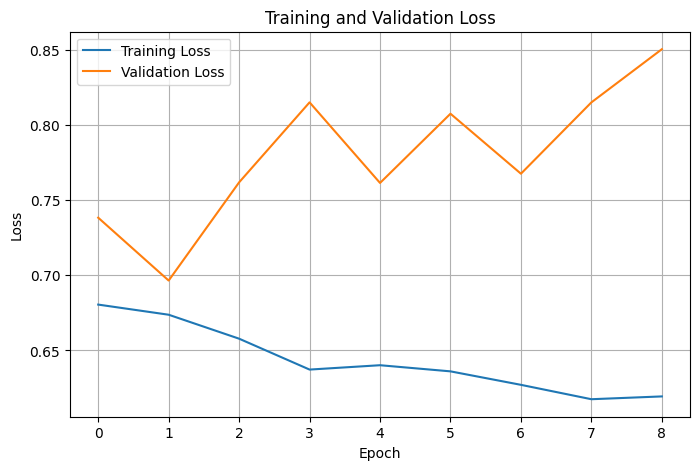

Accuracy: 0.5566
F1 Score: 0.4873
ROC AUC: 0.5501
Confusion Matrix:
[[8683 5301]
 [5828 5288]]
Precision: 0.4994
Recall: 0.4757


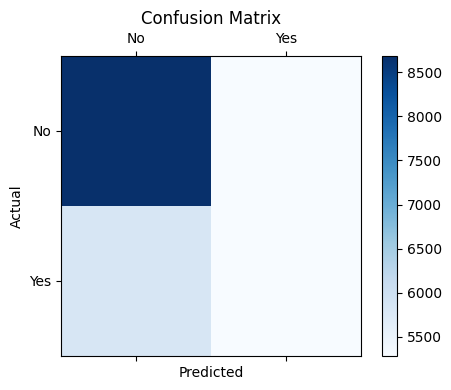

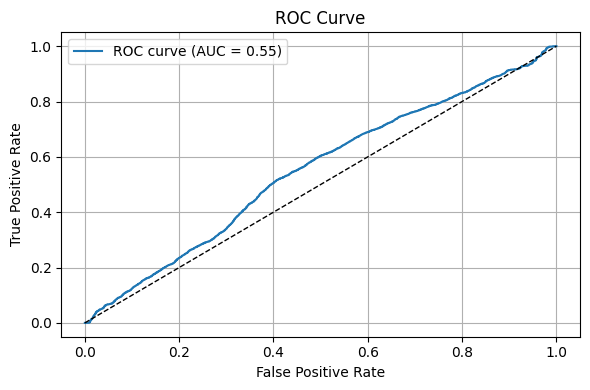

(0.5566135458167331,
 0.4872609997696383,
 np.float64(0.5501241542537073),
 array([[8683, 5301],
        [5828, 5288]]),
 0.499386155444329,
 0.4757106872975891)

In [ ]:
# train_base_lstm_classifier LSTM, 20 symbols, target_6m
target_column = 'target_6m'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'intraday_volatility', 'price_range', 'sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'roc_10', 'var_95', 'target_3m', 'target_1y', 'year', 'month']
types: symbol                          int64
open_v                        float64
high                          float64
low                           float64
close_v                       float64
prev_close                    float64
intraday_volatility           float64
price_range                   float64
sma_5                         float64
sma_20                        float64
rsi_14                        float64
bollinger_upper               float64
bollinger_lower               float64
ema_12                        float64
ema_26                        flo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 128s 41ms/step - accuracy: 0.5033 - auc: 0.5189 - loss: 0.8038 - precision: 0.4138 - recall: 0.5706 - val_accuracy: 0.5627 - val_auc: 0.5551 - val_loss: 0.6865 - val_precision: 0.5080 - val_recall: 0.4006
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 119s 39ms/step - accuracy: 0.5332 - auc: 0.5491 - loss: 0.7091 - precision: 0.4365 - recall: 0.5347 - val_accuracy: 0.5286 - val_auc: 0.5185 - val_loss: 0.7438 - val_precision: 0.4672 - val_recall: 0.4590
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.5543 - auc: 0.5837 - loss: 0.6852 - precision: 0.4564 - recall: 0.5588 - val_accuracy: 0.5465 - val_auc: 0.5603 - val_loss: 0.7155 - val_precision: 0.4873 - val_recall: 0.4628
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.5666 - auc: 0.6077 - loss: 0.6748 - precision: 0.4747 - recall: 0.5975 - val_accuracy: 0.5322 - val_auc: 0.5427 - val_loss: 0.7481 - val_precision: 0.4691 - val_recall: 0.4279
Epoch 5/30
3

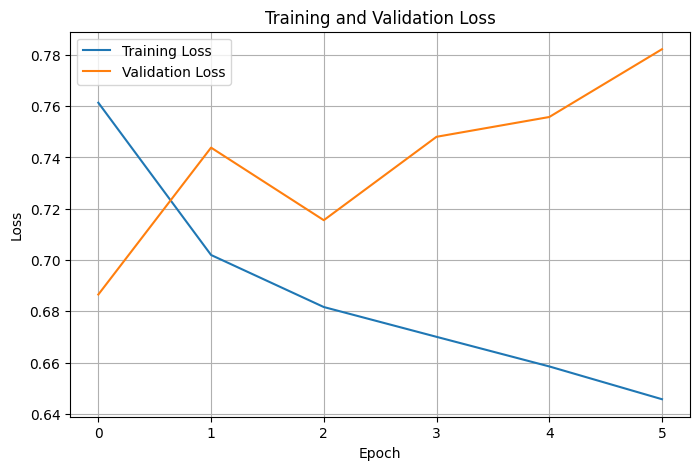

Accuracy: 0.5465
F1 Score: 0.4747
ROC AUC: 0.5603
Confusion Matrix:
[[8572 5412]
 [5972 5144]]
Precision: 0.4873
Recall: 0.4628


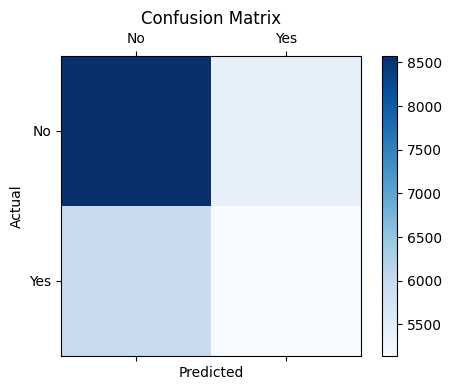

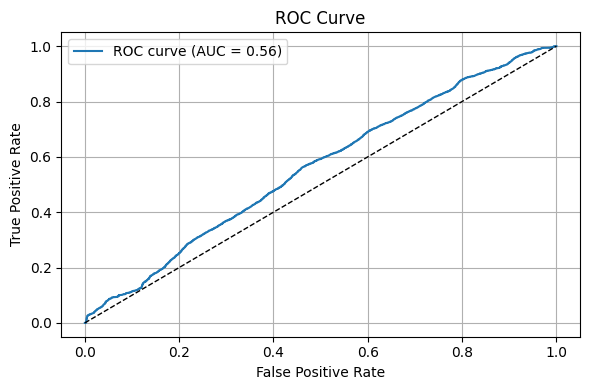

(0.5464541832669323,
 0.47471391657438167,
 np.float64(0.5602829266707317),
 array([[8572, 5412],
        [5972, 5144]]),
 0.48730579765062526,
 0.4627563871896366)

In [ ]:
# train_improved_lstm_classifier LSTM, 20 symbols, target_6m
target_column = 'target_6m'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_6m', 'year']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
prev_volume               float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
rsi_14                    float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
em

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5351 - auc: 0.5532 - loss: 0.6873 - val_accuracy: 0.4545 - val_auc: 0.4387 - val_loss: 0.7675
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5767 - auc: 0.6204 - loss: 0.6634 - val_accuracy: 0.4934 - val_auc: 0.4717 - val_loss: 0.7443
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5687 - auc: 0.6084 - loss: 0.6680 - val_accuracy: 0.4351 - val_auc: 0.4422 - val_loss: 0.7931
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.5924 - auc: 0.6366 - loss: 0.6560 - val_accuracy: 0.4398 - val_auc: 0.4594 - val_loss: 1.0140
Epoch 5/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5540 - auc: 0.5745 - loss: 0.6834 - val_accuracy: 0.4850 - val_auc: 0.4781 - val_loss: 0.9217
Epoch 6/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.6054 - auc: 0.6602 - loss: 0.6393 - val_accuracy: 0.4766 - val_auc: 0.4764 - val_loss: 0.9544
Epoch 7/30
3012/

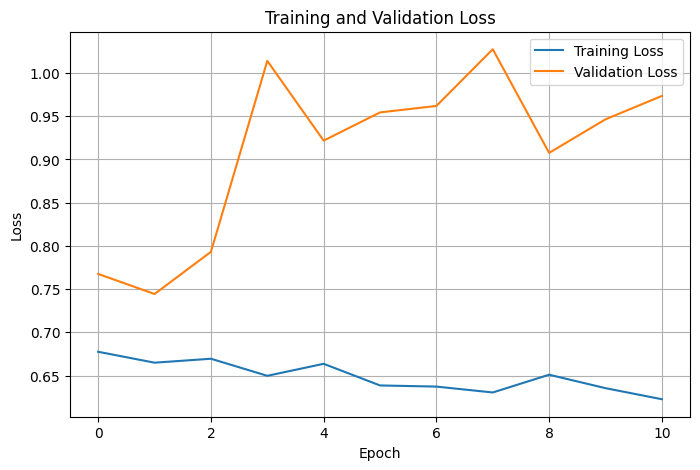

Accuracy: 0.4925
F1 Score: 0.3521
ROC AUC: 0.4922
Confusion Matrix:
[[8901 3880]
 [8858 3461]]
Precision: 0.4715
Recall: 0.2809


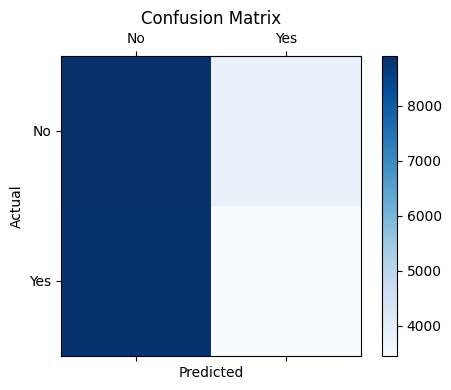

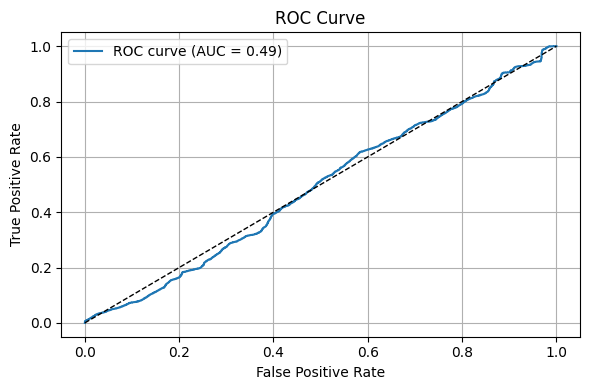

(0.49250996015936255,
 0.3520854526958291,
 np.float64(0.49224298711471515),
 array([[8901, 3880],
        [8858, 3461]]),
 0.47146165372565046,
 0.2809481289065671)

In [ ]:
# train_base_lstm_classifier LSTM, 20 symbols, target_1y
target_column = 'target_1y'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (125466, 56)
Shape after: (125466, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_6m', 'year']
---------------------------------------
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
prev_volume               float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
rsi_14                    float64
bollinger_upper           float64
bollinger_lower           floa

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 127s 40ms/step - accuracy: 0.5123 - auc: 0.5131 - loss: 0.8498 - precision: 0.5250 - recall: 0.6197 - val_accuracy: 0.4928 - val_auc: 0.4831 - val_loss: 0.7554 - val_precision: 0.4701 - val_recall: 0.2619
Epoch 2/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 120s 40ms/step - accuracy: 0.5269 - auc: 0.5415 - loss: 0.7163 - precision: 0.5435 - recall: 0.5314 - val_accuracy: 0.4608 - val_auc: 0.4495 - val_loss: 0.8103 - val_precision: 0.4307 - val_recall: 0.3064
Epoch 3/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 119s 40ms/step - accuracy: 0.5508 - auc: 0.5777 - loss: 0.6882 - precision: 0.5683 - recall: 0.5594 - val_accuracy: 0.4583 - val_auc: 0.4603 - val_loss: 0.8140 - val_precision: 0.4221 - val_recall: 0.2807
Epoch 4/30
3012/3012 ━━━━━━━━━━━━━━━━━━━━ 119s 40ms/step - accuracy: 0.5771 - auc: 0.6148 - loss: 0.6705 - precision: 0.5943 - recall: 0.5892 - val_accuracy: 0.4828 - val_auc: 0.4748 - val_loss: 0.8330 - val_precision: 0.4659 - val_recall: 0.3672
785/785 ━━━━

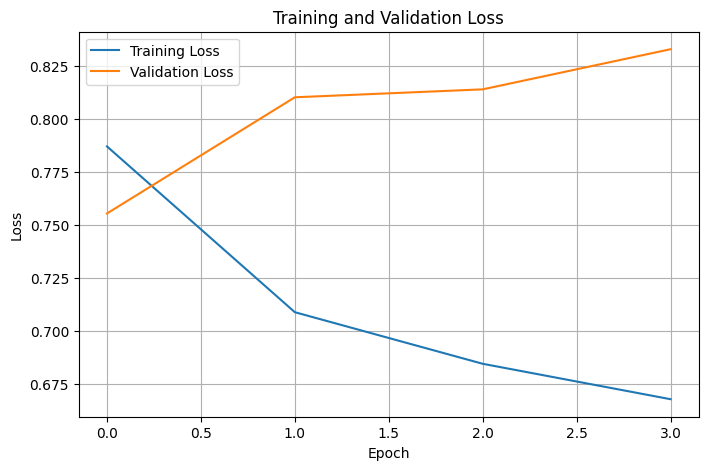

Accuracy: 0.4928
F1 Score: 0.3364
ROC AUC: 0.4834
Confusion Matrix:
[[9144 3637]
 [9093 3226]]
Precision: 0.4701
Recall: 0.2619


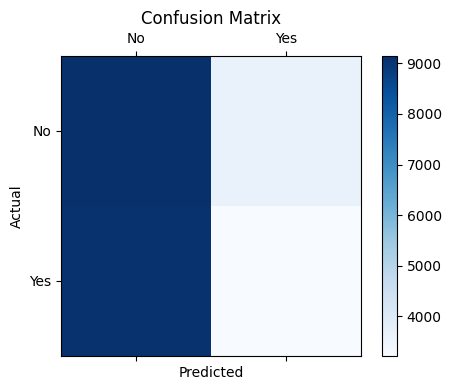

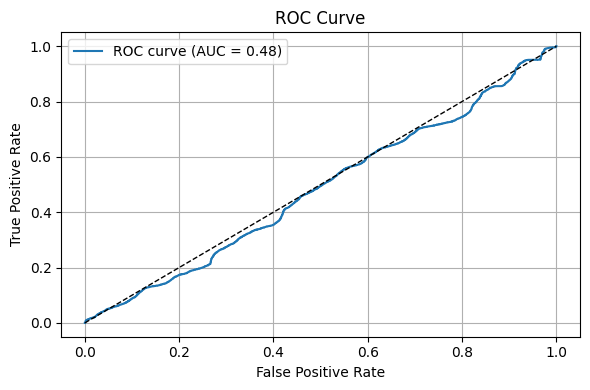

(0.4928286852589641,
 0.3363570013554374,
 np.float64(0.4833728020576854),
 array([[9144, 3637],
        [9093, 3226]]),
 0.47005682646073144,
 0.26187190518710934)

In [ ]:
# train_improved_lstm_classifier LSTM, 20 symbols, target_1y
target_column = 'target_1y'
sequence_length = 200

df_clean = df_20_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print("---------------------------------------")
print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")
print(f"shape: {df_processed_minmax.shape}")
print("---------------------------------------")


X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

# 100 *symbols*

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'close_change_pct', 'price_range', 'log_return', 'sma_5', 'sma_20', 'gain', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'true_range', 'atr_14', 'candle_body', 'momentum_10', 'roc_10', 'var_95', 'target_6m', 'target_1y', 'month']
types: symbol                       int64
open_v                     float64
high                       float64
low                        float64
close_v                    float64
prev_close                 float64
close_change_pct           float64
price_range                float64
log_return                 float64
sma_5                      float64
sma_20                     float64
gain                       float64
rsi_14                     float64
bollinger_upper            float64
bollinger_lower            float64
ema_12                     float64
e

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 117s 7ms/step - accuracy: 0.5164 - auc: 0.5302 - loss: 0.6940 - val_accuracy: 0.6365 - val_auc: 0.5905 - val_loss: 0.6643
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - accuracy: 0.5557 - auc: 0.5676 - loss: 0.6852 - val_accuracy: 0.5774 - val_auc: 0.5900 - val_loss: 0.6677
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - accuracy: 0.5577 - auc: 0.5828 - loss: 0.6823 - val_accuracy: 0.6457 - val_auc: 0.6027 - val_loss: 0.6508
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - accuracy: 0.5531 - auc: 0.5890 - loss: 0.6814 - val_accuracy: 0.5994 - val_auc: 0.6121 - val_loss: 0.6640
Epoch 5/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - accuracy: 0.5678 - auc: 0.5963 - loss: 0.6784 - val_accuracy: 0.5415 - val_auc: 0.6011 - val_loss: 0.6780
Epoch 6/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - accuracy: 0.5730 - auc: 0.6020 - loss: 0.6753 - val_accuracy: 0.5403 - val_auc: 0.6088 - val_loss: 0.6938
Epoc

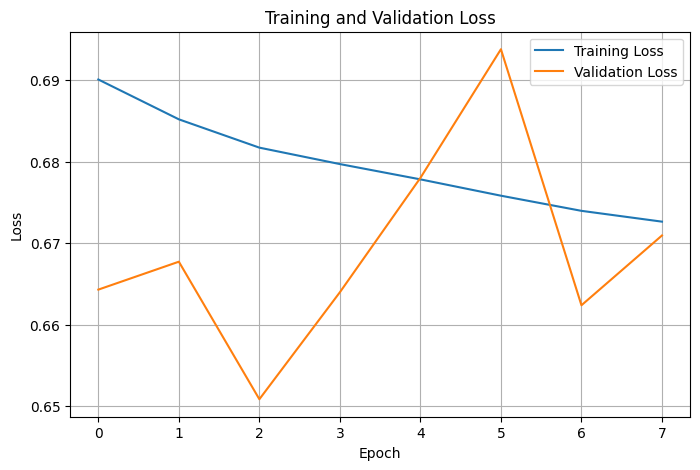

Accuracy: 0.5994
F1 Score: 0.4301
ROC AUC: 0.6122
Confusion Matrix:
[[55876 33370]
 [16555 18836]]
Precision: 0.3608
Recall: 0.5322


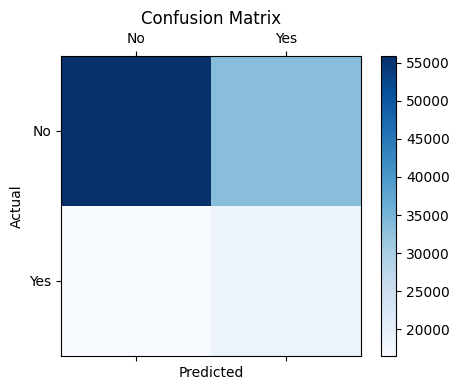

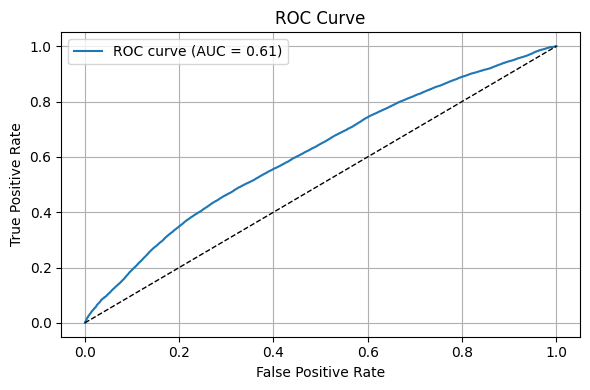

(0.5994367643637122,
 0.4300603901960113,
 np.float64(0.6122402412290989),
 array([[55876, 33370],
        [16555, 18836]]),
 0.36080144044745815,
 0.5322257071006753)

In [ ]:
# train_base_lstm_classifier LSTM, 100 symbols, target_3m
target_column = 'target_3m'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'close_change_pct', 'price_range', 'log_return', 'sma_5', 'sma_20', 'gain', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'true_range', 'atr_14', 'candle_body', 'momentum_10', 'roc_10', 'var_95', 'target_6m', 'target_1y', 'month']
types: symbol                       int64
open_v                     float64
high                       float64
low                        float64
close_v                    float64
prev_close                 float64
close_change_pct           float64
price_range                float64
log_return                 float64
sma_5                      float64
sma_20                     float64
gain                       float64
rsi_14                     float64
bollinger_upper            float64
bollinger_lower            float64
ema_12                     float64
e

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 323s 21ms/step - accuracy: 0.5098 - auc: 0.5058 - loss: 0.7477 - precision: 0.2632 - recall: 0.4942 - val_accuracy: 0.6074 - val_auc: 0.5891 - val_loss: 0.6624 - val_precision: 0.3573 - val_recall: 0.4786
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 314s 20ms/step - accuracy: 0.5239 - auc: 0.5621 - loss: 0.6878 - precision: 0.2931 - recall: 0.5886 - val_accuracy: 0.4286 - val_auc: 0.5526 - val_loss: 0.7357 - val_precision: 0.2965 - val_recall: 0.7375
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 315s 20ms/step - accuracy: 0.5580 - auc: 0.5895 - loss: 0.6804 - precision: 0.3118 - recall: 0.5842 - val_accuracy: 0.4539 - val_auc: 0.5968 - val_loss: 0.7141 - val_precision: 0.3139 - val_recall: 0.7789
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 315s 20ms/step - accuracy: 0.5649 - auc: 0.5984 - loss: 0.6778 - precision: 0.3170 - recall: 0.5867 - val_accuracy: 0.4875 - val_auc: 0.5858 - val_loss: 0.7243 - val_precision: 0.3177 - val_recall: 0.7012
Epoc

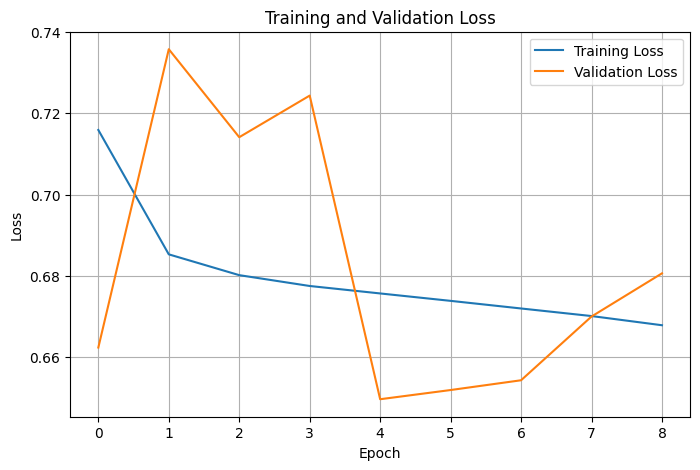

Accuracy: 0.6173
F1 Score: 0.4171
ROC AUC: 0.6087
Confusion Matrix:
[[59870 29376]
 [18324 17067]]
Precision: 0.3675
Recall: 0.4822


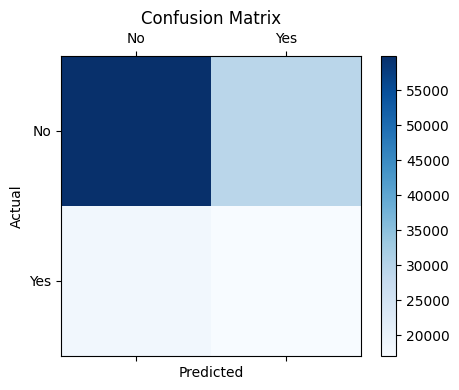

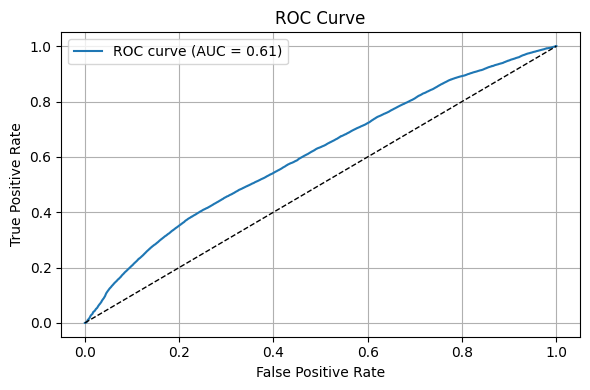

(0.6172886061121496,
 0.41711269154630104,
 np.float64(0.6086872149273717),
 array([[59870, 29376],
        [18324, 17067]]),
 0.36748272075447325,
 0.482241247774858)

In [ ]:
# train_improved_lstm_classifier LSTM, 100 symbols, target_3m
target_column = 'target_3m'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier (
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'momentum_10', 'var_95', 'target_3m', 'target_1y', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
macd_signal              

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 116s 7ms/step - accuracy: 0.5362 - auc: 0.5379 - loss: 0.6909 - val_accuracy: 0.5925 - val_auc: 0.5744 - val_loss: 0.6743
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5445 - auc: 0.5630 - loss: 0.6867 - val_accuracy: 0.5452 - val_auc: 0.5741 - val_loss: 0.6875
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5456 - auc: 0.5715 - loss: 0.6850 - val_accuracy: 0.5686 - val_auc: 0.5757 - val_loss: 0.6788
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5435 - auc: 0.5780 - loss: 0.6831 - val_accuracy: 0.5420 - val_auc: 0.5790 - val_loss: 0.6850
Epoch 5/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5421 - auc: 0.5835 - loss: 0.6810 - val_accuracy: 0.5304 - val_auc: 0.5759 - val_loss: 0.6863
Epoch 6/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.5427 - auc: 0.5862 - loss: 0.6807 - val_accuracy: 0.5712 - val_auc: 0.5772 - val_loss: 0.6727
Epoc

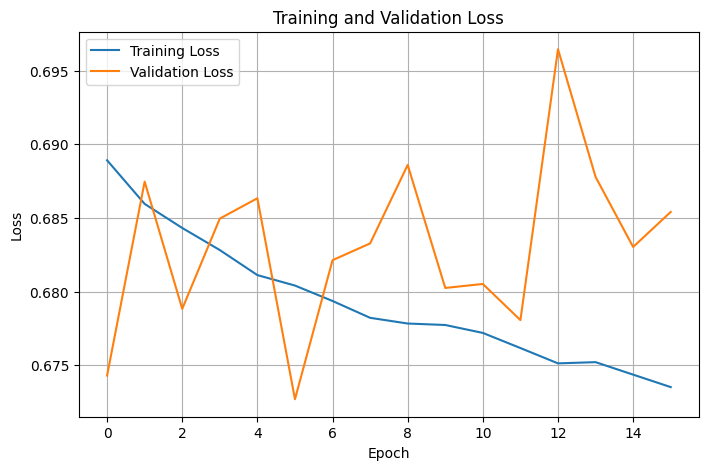

Accuracy: 0.5737
F1 Score: 0.4949
ROC AUC: 0.5893
Confusion Matrix:
[[45465 31200]
 [21937 26035]]
Precision: 0.4549
Recall: 0.5427


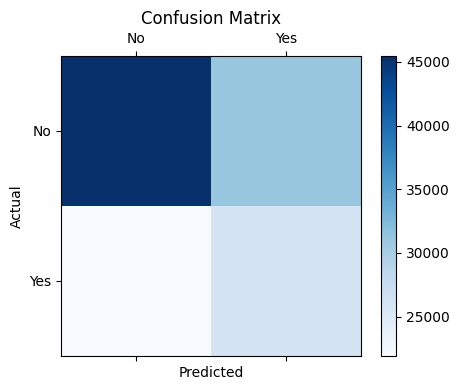

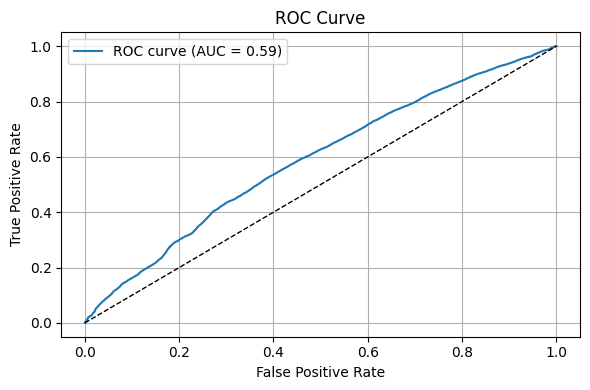

(0.5736659258486645,
 0.4949290446453183,
 np.float64(0.5892991512978974),
 array([[45465, 31200],
        [21937, 26035]]),
 0.4548790076002446,
 0.5427124155757526)

In [ ]:
# train_base_lstm_classifier LSTM, 100 symbols, target_6m
target_column = 'target_6m'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'momentum_10', 'var_95', 'target_3m', 'target_1y', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
macd_signal              

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 319s 20ms/step - accuracy: 0.5068 - auc: 0.5048 - loss: 0.7556 - precision: 0.3725 - recall: 0.4881 - val_accuracy: 0.5721 - val_auc: 0.5559 - val_loss: 0.6858 - val_precision: 0.4264 - val_recall: 0.3240
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 314s 20ms/step - accuracy: 0.5273 - auc: 0.5345 - loss: 0.6917 - precision: 0.3934 - recall: 0.5122 - val_accuracy: 0.5705 - val_auc: 0.5758 - val_loss: 0.6794 - val_precision: 0.4493 - val_recall: 0.5129
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 315s 20ms/step - accuracy: 0.5440 - auc: 0.5694 - loss: 0.6855 - precision: 0.4157 - recall: 0.5754 - val_accuracy: 0.5990 - val_auc: 0.5861 - val_loss: 0.6680 - val_precision: 0.4738 - val_recall: 0.3785
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 315s 20ms/step - accuracy: 0.5496 - auc: 0.5831 - loss: 0.6825 - precision: 0.4237 - recall: 0.5972 - val_accuracy: 0.5758 - val_auc: 0.5881 - val_loss: 0.6703 - val_precision: 0.4524 - val_recall: 0.4848
Epoc

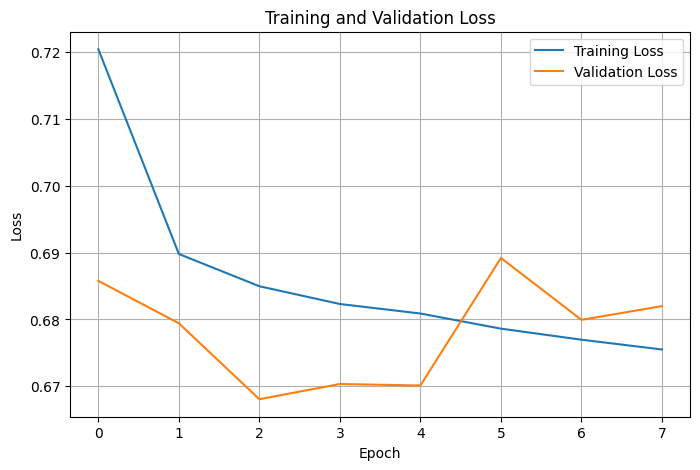

Accuracy: 0.5704
F1 Score: 0.4799
ROC AUC: 0.5940
Confusion Matrix:
[[46380 30285]
 [23265 24707]]
Precision: 0.4493
Recall: 0.5150


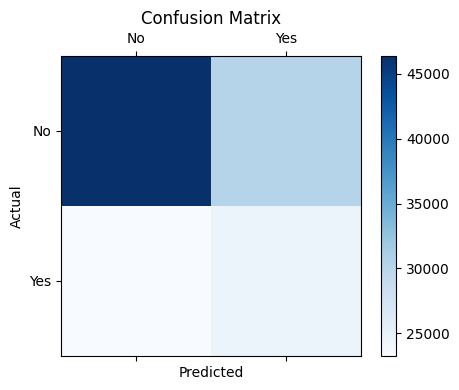

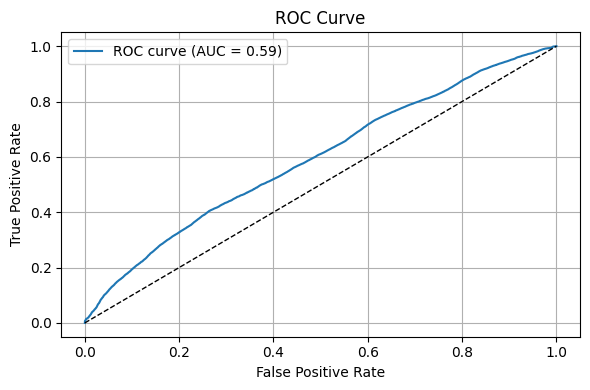

(0.5703523030881681,
 0.4799153102055087,
 np.float64(0.5939717794683695),
 array([[46380, 30285],
        [23265, 24707]]),
 0.44928353215013095,
 0.5150296006003502)

In [ ]:
# train_improved_lstm_classifier LSTM, 100 symbols, target_6m
target_column = 'target_6m'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier (
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_6m', 'year']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
prev_volume               float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.5289 - auc: 0.5393 - loss: 0.6915 - val_accuracy: 0.5437 - val_auc: 0.5391 - val_loss: 0.6972
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5579 - auc: 0.5783 - loss: 0.6826 - val_accuracy: 0.5331 - val_auc: 0.5456 - val_loss: 0.6974
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.5690 - auc: 0.6001 - loss: 0.6749 - val_accuracy: 0.5565 - val_auc: 0.5409 - val_loss: 0.6957
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - accuracy: 0.5814 - auc: 0.6171 - loss: 0.6679 - val_accuracy: 0.5610 - val_auc: 0.5438 - val_loss: 0.7030
Epoch 5/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 116s 8ms/step - accuracy: 0.5881 - auc: 0.6242 - loss: 0.6666 - val_accuracy: 0.5683 - val_auc: 0.5324 - val_loss: 0.7137
Epoch 6/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 116s 8ms/step - accuracy: 0.6045 - auc: 0.6492 - loss: 0.6541 - val_accuracy: 0.5610 - val_auc: 0.5270 - val_loss: 0.7352
3895

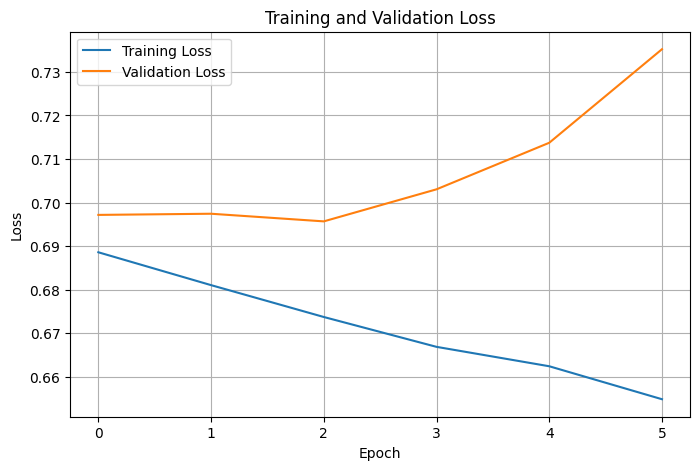

Accuracy: 0.5331
F1 Score: 0.5520
ROC AUC: 0.5458
Confusion Matrix:
[[30585 37764]
 [20431 35857]]
Precision: 0.4870
Recall: 0.6370


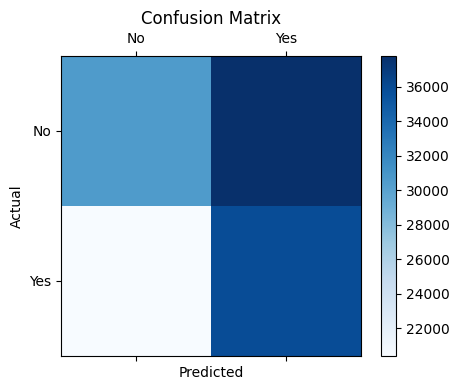

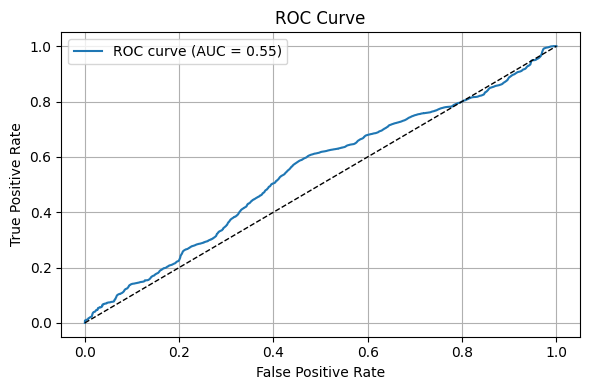

(0.5330840761571604,
 0.5520325766498088,
 np.float64(0.54583539369964),
 array([[30585, 37764],
        [20431, 35857]]),
 0.4870485323481072,
 0.637027430358158)

In [ ]:
# train_base_lstm_classifier LSTM, 100 symbols, target_1y
target_column = 'target_1y'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (622891, 56)
Shape after: (622891, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_6m', 'year']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
volume                    float64
prev_close                float64
prev_volume               float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 325s 21ms/step - accuracy: 0.5043 - auc: 0.5072 - loss: 0.7555 - precision: 0.4803 - recall: 0.5248 - val_accuracy: 0.5422 - val_auc: 0.5333 - val_loss: 0.6908 - val_precision: 0.4845 - val_recall: 0.2149
Epoch 2/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 319s 21ms/step - accuracy: 0.5333 - auc: 0.5475 - loss: 0.6895 - precision: 0.5100 - recall: 0.5062 - val_accuracy: 0.5359 - val_auc: 0.5486 - val_loss: 0.6905 - val_precision: 0.4795 - val_recall: 0.3231
Epoch 3/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 318s 21ms/step - accuracy: 0.5598 - auc: 0.5822 - loss: 0.6821 - precision: 0.5366 - recall: 0.5504 - val_accuracy: 0.5505 - val_auc: 0.5293 - val_loss: 0.6932 - val_precision: 0.5032 - val_recall: 0.3654
Epoch 4/30
15383/15383 ━━━━━━━━━━━━━━━━━━━━ 321s 21ms/step - accuracy: 0.5824 - auc: 0.6180 - loss: 0.6704 - precision: 0.5545 - recall: 0.5983 - val_accuracy: 0.5523 - val_auc: 0.5361 - val_loss: 0.7545 - val_precision: 0.5106 - val_recall: 0.2094
Epoc

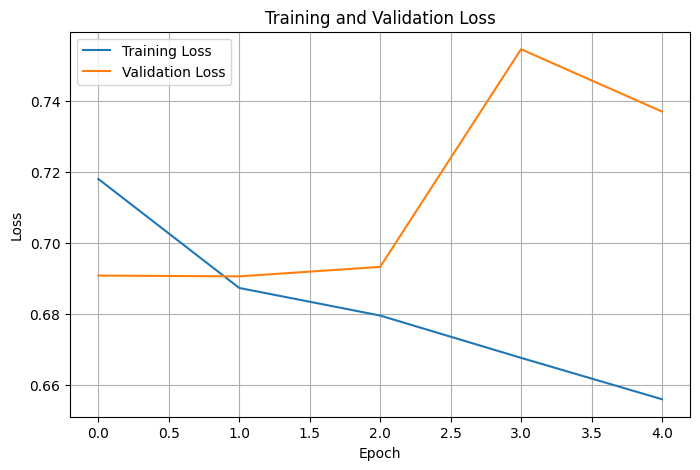

Accuracy: 0.5359
F1 Score: 0.3860
ROC AUC: 0.5494
Confusion Matrix:
[[48611 19738]
 [38104 18184]]
Precision: 0.4795
Recall: 0.3231


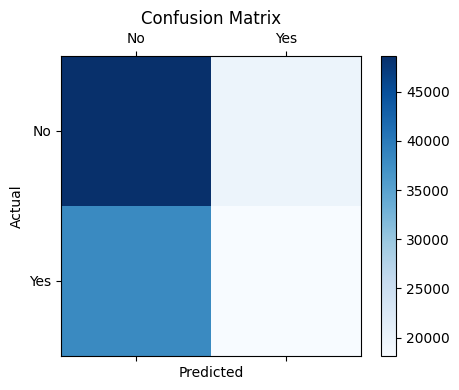

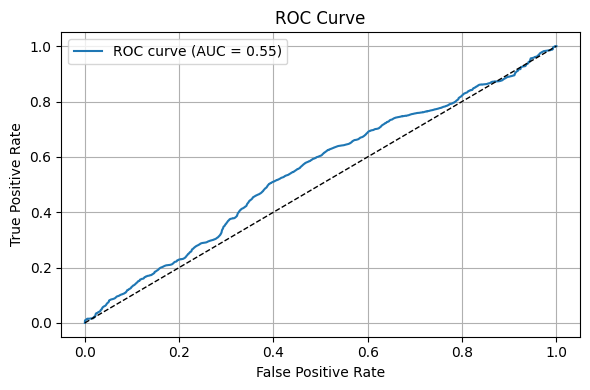

(0.5359163009379238,
 0.3860312068782507,
 np.float64(0.5493755763161697),
 array([[48611, 19738],
        [38104, 18184]]),
 0.47951057433679656,
 0.32305287094940305)

In [ ]:
# train_improved_lstm_classifier LSTM, 100 symbols, target_1y
target_column = 'target_1y'
sequence_length = 60

df_clean = df_100_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier (
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

# 500 symbols

Shape before: (3077632, 56)
Shape after: (3077632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'gap_open', 'log_return', 'is_dividend_day', 'sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'rel_volume', 'ema_12', 'ema_26', 'macd_signal', 'candle_color', 'roc_10', 'var_95', 'target_6m', 'target_1y', 'year', 'month']
types: symbol                          int64
open_v                        float64
high                          float64
low                           float64
close_v                       float64
volume                        float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
gap_open                      float64
log_return                    float64
is_dividend_day               float64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 474s 6ms/step - accuracy: 0.4859 - auc: 0.5094 - loss: 0.6937 - val_accuracy: 0.5417 - val_auc: 0.5281 - val_loss: 0.6818
Epoch 2/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 466s 6ms/step - accuracy: 0.4973 - auc: 0.5325 - loss: 0.6913 - val_accuracy: 0.4689 - val_auc: 0.5301 - val_loss: 0.6846
Epoch 3/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 471s 6ms/step - accuracy: 0.5110 - auc: 0.5380 - loss: 0.6907 - val_accuracy: 0.6629 - val_auc: 0.5350 - val_loss: 0.6734
Epoch 4/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 472s 6ms/step - accuracy: 0.5103 - auc: 0.5452 - loss: 0.6894 - val_accuracy: 0.5146 - val_auc: 0.5482 - val_loss: 0.6797
Epoch 5/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 474s 6ms/step - accuracy: 0.5078 - auc: 0.5493 - loss: 0.6888 - val_accuracy: 0.6864 - val_auc: 0.5329 - val_loss: 0.6535
Epoch 6/30
76470/76470 ━━━━━━━━━━━━━━━━━━━━ 474s 6ms/step - accuracy: 0.5045 - auc: 0.5518 - loss: 0.6887 - val_accuracy: 0.6627 - val_auc: 0.5422 - val_loss: 0.6642
Epoc

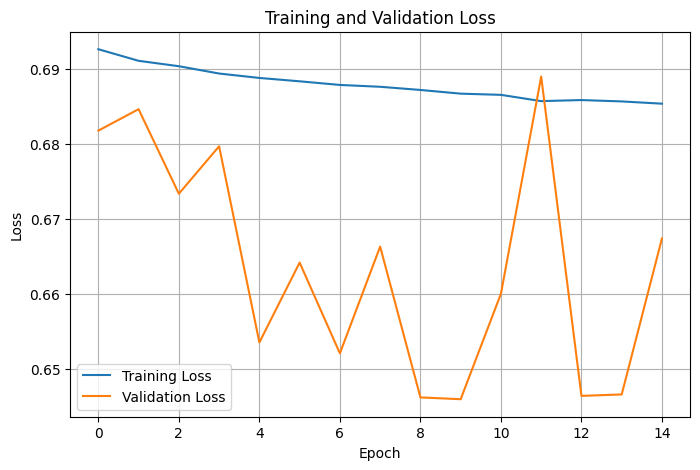

Accuracy: 0.6327
F1 Score: 0.3524
ROC AUC: 0.5673
Confusion Matrix:
[[327951  99231]
 [126893  61528]]
Precision: 0.3827
Recall: 0.3265


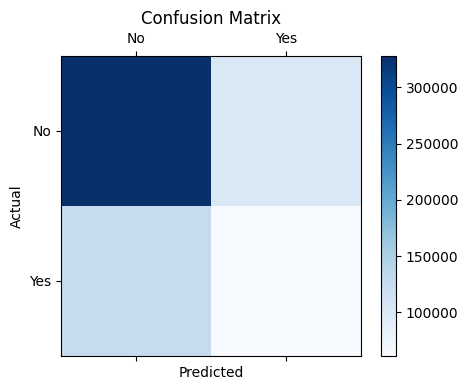

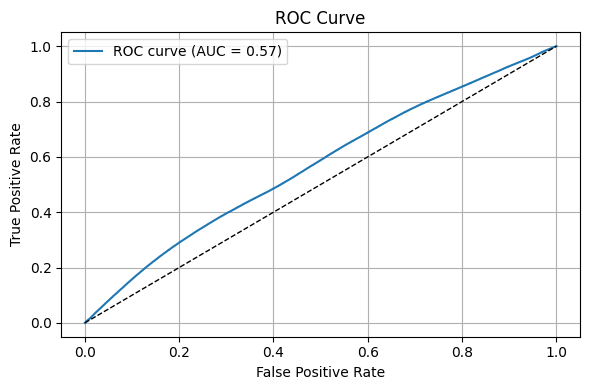

(0.632678853092009,
 0.35241422761899305,
 np.float64(0.5673496540126591),
 array([[327951,  99231],
        [126893,  61528]]),
 0.3827344036725782,
 0.3265453426104309)

In [ ]:
# train_base_lstm_classifier LSTM, 500 symbols, target_3m
target_column = 'target_3m'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (1238632, 56)
Shape after: (1238632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'tr_1', 'tr_2', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'momentum_10', 'roc_10', 'var_95', 'target_6m', 'target_1y', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
rsi_14                    float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
macd_signal          

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 518s 17ms/step - accuracy: 0.5083 - auc: 0.5069 - loss: 0.7343 - precision: 0.2840 - recall: 0.4990 - val_accuracy: 0.6235 - val_auc: 0.5853 - val_loss: 0.6647 - val_precision: 0.3723 - val_recall: 0.3868
Epoch 2/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 508s 17ms/step - accuracy: 0.5486 - auc: 0.5726 - loss: 0.6854 - precision: 0.3244 - recall: 0.5643 - val_accuracy: 0.4632 - val_auc: 0.5812 - val_loss: 0.7179 - val_precision: 0.3264 - val_recall: 0.7559
Epoch 3/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 505s 16ms/step - accuracy: 0.5508 - auc: 0.5874 - loss: 0.6814 - precision: 0.3318 - recall: 0.5950 - val_accuracy: 0.4892 - val_auc: 0.5819 - val_loss: 0.6919 - val_precision: 0.3317 - val_recall: 0.7065
Epoch 4/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 508s 17ms/step - accuracy: 0.5522 - auc: 0.5926 - loss: 0.6790 - precision: 0.3332 - recall: 0.6018 - val_accuracy: 0.5622 - val_auc: 0.5995 - val_loss: 0.6708 - val_precision: 0.3587 - val_recall: 0.5979
Epoc

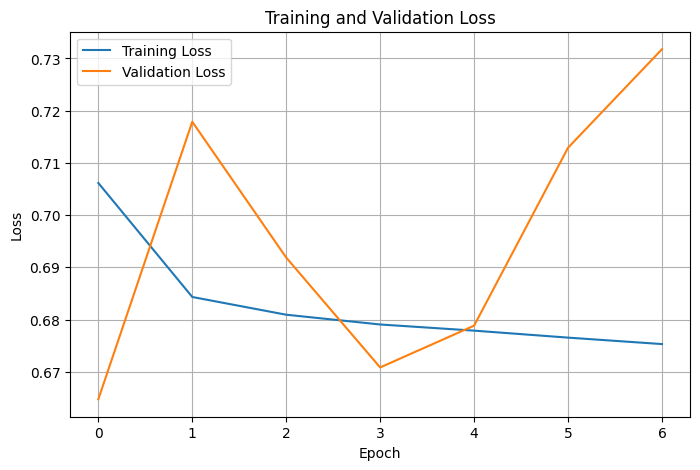

Accuracy: 0.5622
F1 Score: 0.4484
ROC AUC: 0.5996
Confusion Matrix:
[[95240 78832]
 [29645 44086]]
Precision: 0.3587
Recall: 0.5979


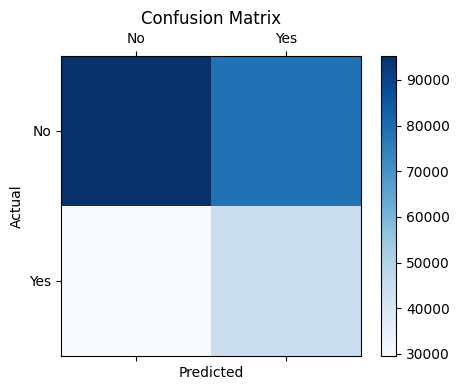

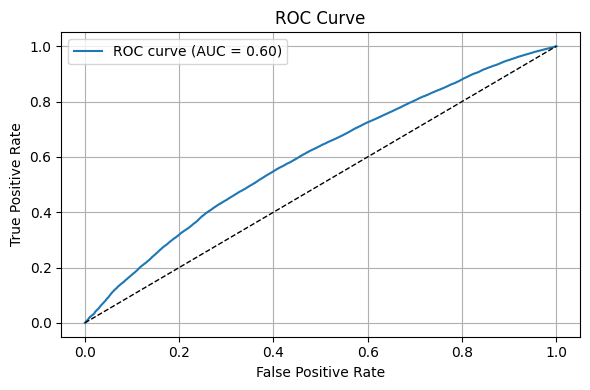

(0.5622450091403252,
 0.44837248091777737,
 np.float64(0.5996149762993013),
 array([[95240, 78832],
        [29645, 44086]]),
 0.35866187214240386,
 0.597930314250451)

In [ ]:
# train_improved_lstm_classifier LSTM, 500 symbols, target_3m
target_column = 'target_3m'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (1238632, 56)
Shape after: (1238632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_1y', 'year', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
rsi_14                    float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
tr_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 202s 7ms/step - accuracy: 0.5292 - auc: 0.5404 - loss: 0.6905 - val_accuracy: 0.5543 - val_auc: 0.5608 - val_loss: 0.6828
Epoch 2/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - accuracy: 0.5341 - auc: 0.5609 - loss: 0.6868 - val_accuracy: 0.5619 - val_auc: 0.5618 - val_loss: 0.6822
Epoch 3/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - accuracy: 0.5373 - auc: 0.5647 - loss: 0.6858 - val_accuracy: 0.5698 - val_auc: 0.5606 - val_loss: 0.6809
Epoch 4/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 201s 7ms/step - accuracy: 0.5411 - auc: 0.5705 - loss: 0.6838 - val_accuracy: 0.5769 - val_auc: 0.5584 - val_loss: 0.6767
Epoch 5/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - accuracy: 0.5390 - auc: 0.5737 - loss: 0.6827 - val_accuracy: 0.5850 - val_auc: 0.5689 - val_loss: 0.6733
Epoch 6/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 199s 6ms/step - accuracy: 0.5431 - auc: 0.5764 - loss: 0.6814 - val_accuracy: 0.5692 - val_auc: 0.5538 - val_loss: 0.6908
Epoc

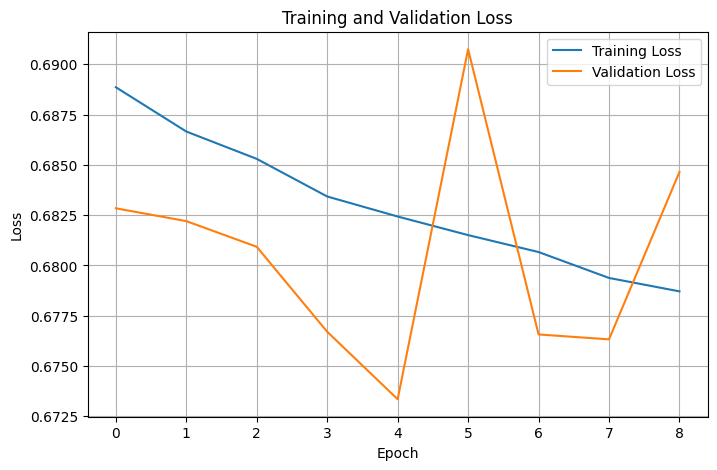

Accuracy: 0.5850
F1 Score: 0.4097
ROC AUC: 0.5689
Confusion Matrix:
[[109286  40926]
 [ 61901  35690]]
Precision: 0.4658
Recall: 0.3657


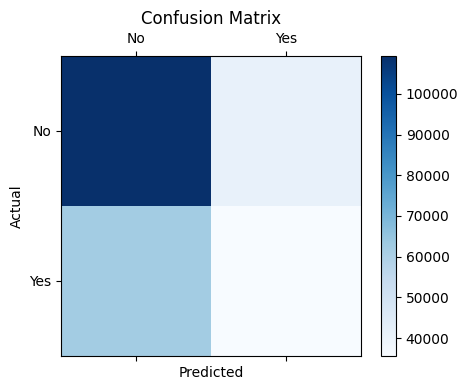

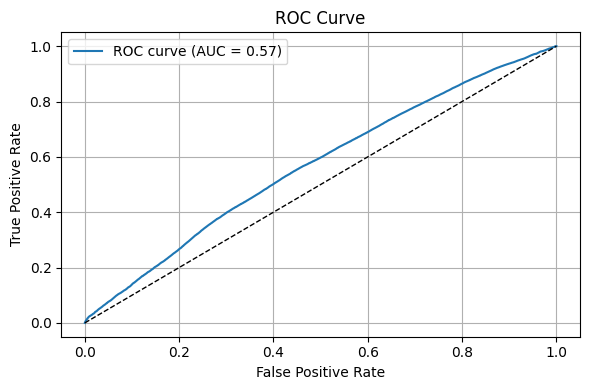

(0.5850453787887959,
 0.40974243285287043,
 np.float64(0.5688951326101827),
 array([[109286,  40926],
        [ 61901,  35690]]),
 0.4658295917301869,
 0.3657099527620375)

In [ ]:
# train_base_lstm_classifier LSTM, 500 symbols, target_6m
target_column = 'target_6m'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (1238632, 56)
Shape after: (1238632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'var_95', 'target_3m', 'target_1y', 'year', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
rsi_14                    float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
tr_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 526s 17ms/step - accuracy: 0.5062 - auc: 0.5102 - loss: 0.7313 - precision: 0.3989 - recall: 0.5163 - val_accuracy: 0.5063 - val_auc: 0.5498 - val_loss: 0.6904 - val_precision: 0.4143 - val_recall: 0.6127
Epoch 2/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 518s 17ms/step - accuracy: 0.5303 - auc: 0.5588 - loss: 0.6878 - precision: 0.4289 - recall: 0.6055 - val_accuracy: 0.6007 - val_auc: 0.5668 - val_loss: 0.6684 - val_precision: 0.4787 - val_recall: 0.1568
Epoch 3/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 520s 17ms/step - accuracy: 0.5461 - auc: 0.5778 - loss: 0.6840 - precision: 0.4418 - recall: 0.6050 - val_accuracy: 0.6010 - val_auc: 0.5665 - val_loss: 0.6706 - val_precision: 0.4863 - val_recall: 0.2315
Epoch 4/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 516s 17ms/step - accuracy: 0.5571 - auc: 0.5872 - loss: 0.6816 - precision: 0.4504 - recall: 0.5917 - val_accuracy: 0.5878 - val_auc: 0.5454 - val_loss: 0.6777 - val_precision: 0.4553 - val_recall: 0.2369
Epoc

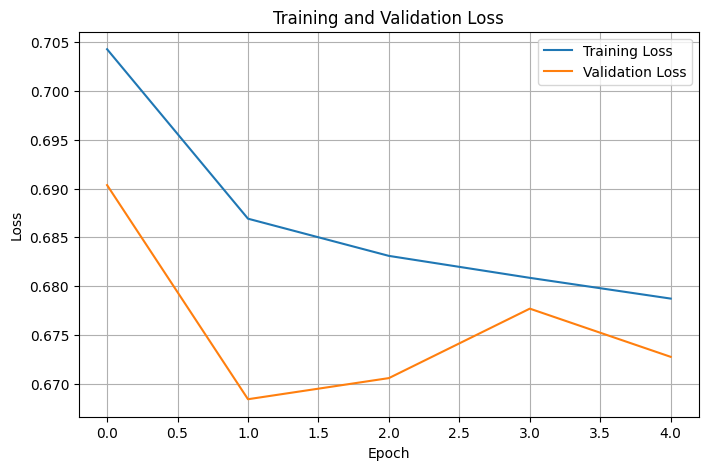

Accuracy: 0.6007
F1 Score: 0.2363
ROC AUC: 0.5668
Confusion Matrix:
[[133548  16664]
 [ 82286  15305]]
Precision: 0.4787
Recall: 0.1568


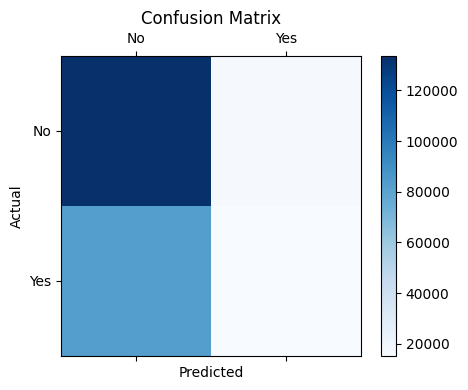

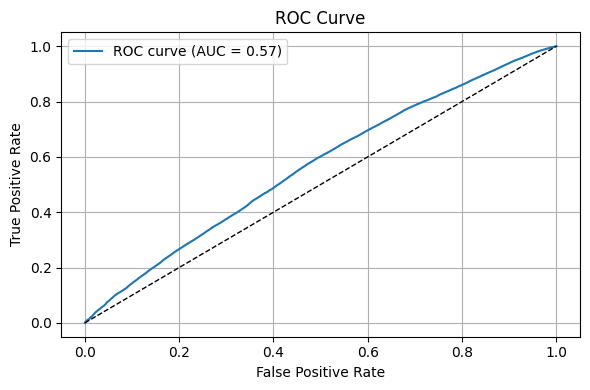

(0.600690871377667,
 0.2362611917258413,
 np.float64(0.56676696005898),
 array([[133548,  16664],
        [ 82286,  15305]]),
 0.47874503425193154,
 0.15682798618725088)

In [ ]:
# train_improved_lstm_classifier LSTM, 500 symbols, target_6m
target_column = 'target_6m'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (1238632, 56)
Shape after: (1238632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'momentum_10', 'var_95', 'target_3m', 'target_6m', 'year', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
tr_1                      float6

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.5200 - auc: 0.5299 - loss: 0.6917 - val_accuracy: 0.5257 - val_auc: 0.5417 - val_loss: 0.6958
Epoch 2/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 206s 7ms/step - accuracy: 0.5332 - auc: 0.5504 - loss: 0.6872 - val_accuracy: 0.5387 - val_auc: 0.5425 - val_loss: 0.7041
Epoch 3/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.5411 - auc: 0.5643 - loss: 0.6826 - val_accuracy: 0.5359 - val_auc: 0.5321 - val_loss: 0.7263
Epoch 4/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.5489 - auc: 0.5764 - loss: 0.6791 - val_accuracy: 0.5307 - val_auc: 0.5229 - val_loss: 0.7288
Epoch 5/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.5534 - auc: 0.5833 - loss: 0.6771 - val_accuracy: 0.5283 - val_auc: 0.5246 - val_loss: 0.7241
Epoch 6/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - accuracy: 0.5559 - auc: 0.5900 - loss: 0.6734 - val_accuracy: 0.5262 - val_auc: 0.5281 - val_loss: 0.7337
7744

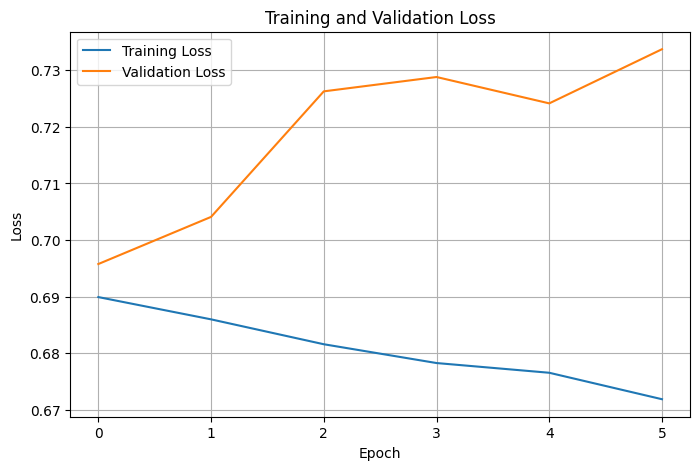

Accuracy: 0.5387
F1 Score: 0.5250
ROC AUC: 0.5427
Confusion Matrix:
[[70345 60662]
 [53639 63157]]
Precision: 0.5101
Recall: 0.5407


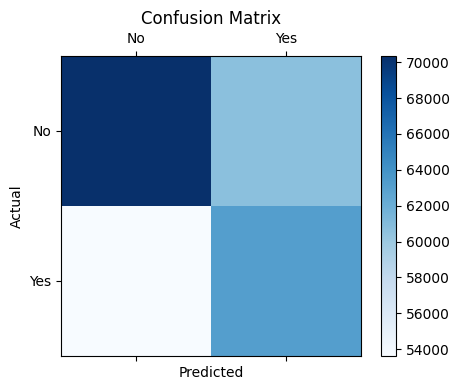

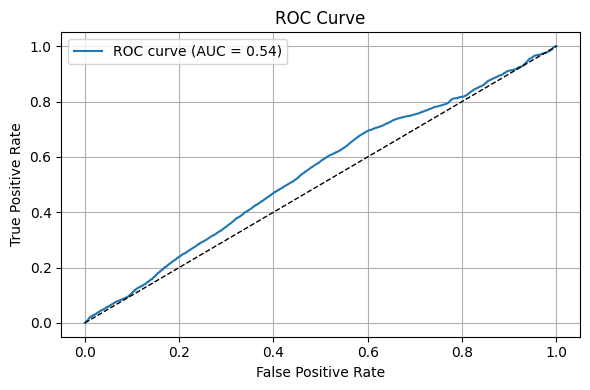

(0.5387424688159546,
 0.5249631153502483,
 np.float64(0.5426927319884767),
 array([[70345, 60662],
        [53639, 63157]]),
 0.5100751903988887,
 0.540746258433508)

In [ ]:
# train_base_lstm_classifier LSTM, 500 symbols, target_1y
target_column = 'target_1y'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_base_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (1238632, 56)
Shape after: (1238632, 49)
Scaled columns used: ['symbol', 'open_v', 'high', 'low', 'close_v', 'prev_close', 'price_range', 'sma_5', 'sma_20', 'gain', 'loss', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'ema_26', 'macd_line', 'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'momentum_10', 'var_95', 'target_3m', 'target_6m', 'year', 'month']
types: symbol                      int64
open_v                    float64
high                      float64
low                       float64
close_v                   float64
prev_close                float64
price_range               float64
sma_5                     float64
sma_20                    float64
gain                      float64
loss                      float64
bollinger_upper           float64
bollinger_lower           float64
ema_12                    float64
ema_26                    float64
macd_line                 float64
tr_1                      float6

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 529s 17ms/step - accuracy: 0.5064 - auc: 0.5076 - loss: 0.7429 - precision: 0.5047 - recall: 0.4746 - val_accuracy: 0.5239 - val_auc: 0.5422 - val_loss: 0.6891 - val_precision: 0.4929 - val_recall: 0.3491
Epoch 2/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 520s 17ms/step - accuracy: 0.5358 - auc: 0.5499 - loss: 0.6891 - precision: 0.5284 - recall: 0.6354 - val_accuracy: 0.5259 - val_auc: 0.5439 - val_loss: 0.6896 - val_precision: 0.4967 - val_recall: 0.4486
Epoch 3/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 523s 17ms/step - accuracy: 0.5475 - auc: 0.5691 - loss: 0.6850 - precision: 0.5386 - recall: 0.6375 - val_accuracy: 0.5318 - val_auc: 0.5446 - val_loss: 0.6938 - val_precision: 0.5071 - val_recall: 0.2406
Epoch 4/30
30776/30776 ━━━━━━━━━━━━━━━━━━━━ 519s 17ms/step - accuracy: 0.5572 - auc: 0.5897 - loss: 0.6785 - precision: 0.5506 - recall: 0.6005 - val_accuracy: 0.5295 - val_auc: 0.5364 - val_loss: 0.7008 - val_precision: 0.5023 - val_recall: 0.1854
Epoc

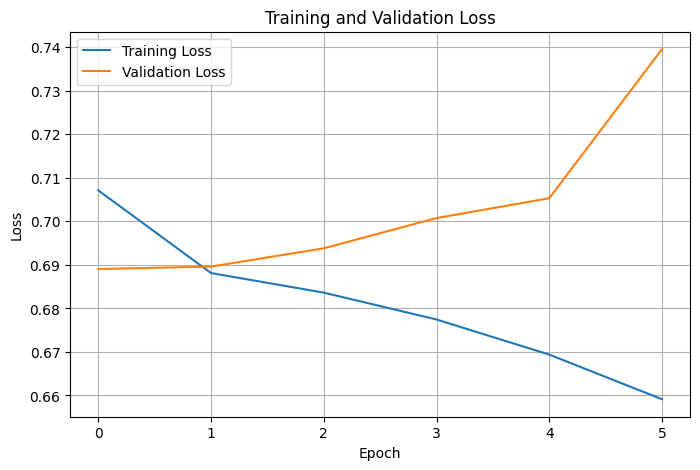

Accuracy: 0.5318
F1 Score: 0.3263
ROC AUC: 0.5451
Confusion Matrix:
[[103693  27314]
 [ 88698  28098]]
Precision: 0.5071
Recall: 0.2406


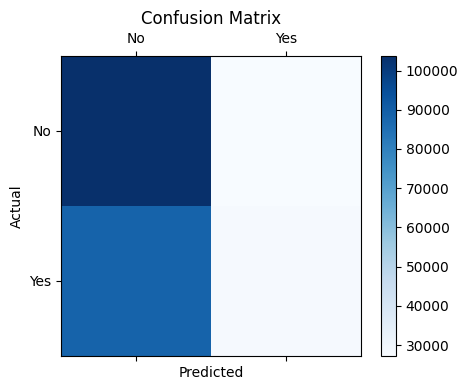

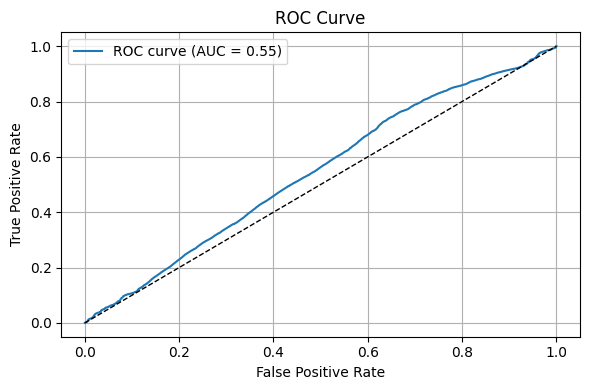

(0.5318377905029399,
 0.32632630307535077,
 np.float64(0.5450713351143737),
 array([[103693,  27314],
        [ 88698,  28098]]),
 0.5070742799393633,
 0.2405733073050447)

In [ ]:
# train_improved_lstm_classifier LSTM, 500 symbols, target_1y
target_column = 'target_1y'
sequence_length = 30

df_clean = df_500_symbols.copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])

df_clean = clean_columns(df_clean)

df_processed_minmax, scaler_minmax, selected_features = prepare_data_with_symbol_date_k_features(
    df_clean,
    target=target_column,
    k_best=30
)

print(f"types: {df_processed_minmax.dtypes}")
print(f"columns: {df_processed_minmax.columns}")

X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

print("Missing values in target:", df_processed_minmax[target_column].isnull().sum())

# Balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Training
model, X_test, y_test, y_prob, y_pred, history = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)